<a href="https://colab.research.google.com/github/afujii/NLTK/blob/master/RDFLib%E7%99%BE%E4%BA%BA%E4%B8%80%E9%A6%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RDFLibと百人一種
はじめに、ドライブをマウントして、CSVファイルを読み込む。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open('/content/drive/MyDrive/Colab Notebooks/hyakuninUTF8.txt',encoding='UTF8') as fp:
  utas = fp.readlines()

ライブラリを用意しRDFLib のグラフを作成する。

In [5]:
!pip install rdflib

     |████████████████████████████████| 407 kB 5.1 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 


In [6]:
from rdflib import Graph, Literal, URIRef, Namespace
from rdflib.namespace import FOAF

g = Graph()

ライブラリを用意し、グラフにデータを読み込む。　<br>
今回の例で使用した　s, p, o の関係は以下。　<br>
|yomiteID -FOAF.name-> Literal() <br>
 yomiteID -utaid-> utaID <br>
 utaID -utaliteral-> Literal() <br>
 utaID -kami-> kamiID <br>
 utaID -simo-> simoID <br>
 kamiID -kanji-> Literal <br>
 simoID -kanji-> Literal <br>
 kamiID -kana-> Literal <br>
simoID -kana-> Litral <br>

In [7]:
head  = utas.pop(0)# utas は、No.1 からの全データ（list）になる。

yomite = [ uta.split(',')[1] for uta in utas ] #読み手
kamikanji = [ uta.split(',')[2] for uta in utas ] #上の句（漢字）
simokanji = [ uta.split(',')[3] for uta in utas ] #下の句（漢字）
kamikana = [ uta.split(',')[4] for uta in utas ] #上の句（かな）
simokana = [ uta.split(',')[5] for uta in utas ] #下の句（かな）

############################################
ns = Namespace("http://hyakunin.com#")
yomiteIDs = [URIRef( "ID"+str(i).zfill(3))  for i in range(1,101)]
utaIDs = [ URIRef("utaID"+str(i).zfill(3))  for i in range(1,101)]
kamiIDs = [ URIRef("kamiID"+str(i).zfill(3))  for i in range(1,101)]
simoIDs = [ URIRef("simoID"+str(i).zfill(3))  for i in range(1,101)]

for i in range(0,100):
  g.add((yomiteIDs[i],FOAF.name,Literal(yomite[i])))
  g.add((yomiteIDs[i],ns['utaid'],utaIDs[i]))
  #####################
  g.add((utaIDs[i],ns['utaliteral'],Literal(kamikanji[i]+simokanji[i])))
  g.add((utaIDs[i],ns['kami'],kamiIDs[i]))
  g.add((utaIDs[i],ns['simo'],simoIDs[i]))
  #####################
  g.add((kamiIDs[i],ns['kanji'],Literal(kamikanji[i])))
  g.add((kamiIDs[i],ns['kana'],Literal(kamikana[i])))
  g.add((simoIDs[i],ns['kanji'],Literal(simokanji[i])))
  g.add((simoIDs[i],ns['kana'],Literal(simokana[i])))



In [8]:
######### 以上で　g の準備ができた
# 視覚化 百人一首全体では、大きいので「天智天皇」のみ

newg = Graph()
for s, p, o in g.triples((URIRef("ID001"), None, None)):
  newg.add((s,p,o))
for s, p, o in g.triples((URIRef("utaID001"),None,None)):
  newg.add((s,p,o))
############## 共通項の utaID001 は、自動的に共有される

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31179 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12363 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12426 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12411 missing from current font.
  font.set_

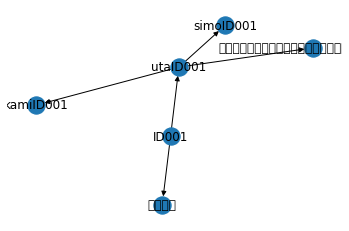

In [9]:
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
import matplotlib.pyplot as plt

G = rdflib_to_networkx_multidigraph(newg)# 部分グラフ newg 

# Plot Networkx instance of RDF Graph
pos = nx.spring_layout(G, scale=2)
edge_labels = nx.get_edge_attributes(G, 'r')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw(G, with_labels=True)
plt.show()


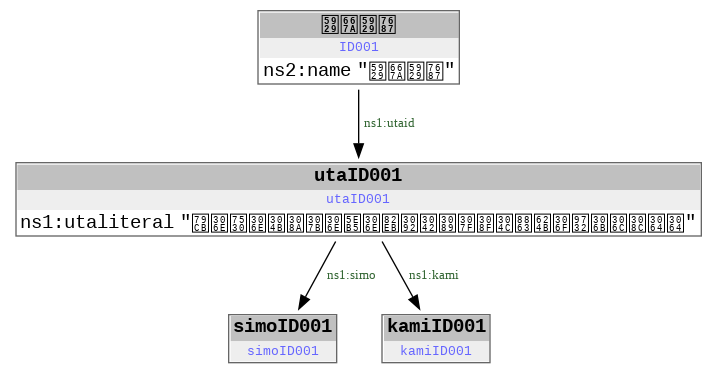

In [10]:
############ 別の視覚化ライブラリを試す
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot
def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))

visualize(newg)